In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
from scipy import stats
import matplotlib.pyplot as plt
import pandas_profiling
from pandas_profiling import ProfileReport

df = pd.read_csv("extract-3-very-clean.csv", index_col=['Contract date'])

In [2]:
#See how many records are included
df.size

18742005

In [3]:
df.index

Index(['2014-11-05', '2014-11-24', '2014-11-20', '2014-10-03', '2014-09-04',
       '2014-08-14', '2014-11-28', '2014-10-17', '2014-10-31', '2014-11-08',
       ...
       '2018-12-18', '2021-01-11', '2018-06-20', '2021-01-22', '2020-12-24',
       '2021-01-19', '2016-06-16', '2019-01-23', '2013-12-07', '2014-07-15'],
      dtype='object', name='Contract date', length=1249467)

In [4]:
#Check types are okay
df.dtypes

Unnamed: 0                 int64
Property ID              float64
Download date / time      object
Property name             object
Property unit number      object
Property house number     object
Property street name      object
Property locality         object
Property post code       float64
Area                     float64
Settlement date           object
Purchase price           float64
Zoning                    object
Primary purpose           object
Strata lot number        float64
dtype: object

In [5]:
# Create a list of property locations, postcodes and minimum areas you want to search for (could obvs filter by whatever, but this is my search area)
property_locations = ['Lawson','Hazelbrook','Woodford','Linden','Faulconbridge','Springwood','Valley Heights','Warrimoo', 'Blaxland', 'Glenbrook']
postcode_min = 2750
postcode_max = 2800
area_min = 1000

df_myarea = df[(df['Property locality'].isin(property_locations)) & (df['Area'] > area_min) & (df['Property post code'] >= postcode_min) & (df['Property post code'] <= postcode_max) & (df['Primary purpose'] == 'Vacant land')]
print(str(len(df_myarea.index)) + ' records kept')

128 records kept


In [ ]:
profile = ProfileReport(df_myarea, title="Pandas Profiling Report")
profile

In [9]:
#Remove purchase price outliers
df_myarea = df_myarea[(np.abs(stats.zscore(df_myarea['Purchase price'])) < 3)]


array([[<AxesSubplot:title={'center':'Purchase price'}>]], dtype=object)

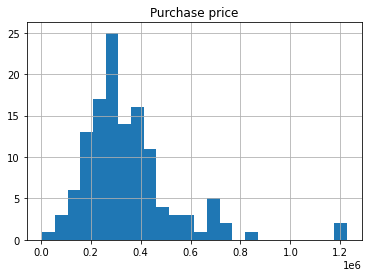

In [10]:
#Price histogram in ~$50K bins
df_myarea.hist(column='Purchase price', bins=int(df_myarea['Purchase price'].max()/50000))

In [26]:
#Get unique
df_myarea['Zoning'].unique()

array(['A', 'R', nan, 'I', 'B', 'E4', 'IN1', 'E3', 'R2', 'B7', 'IN2',
       'R3', 'E2'], dtype=object)

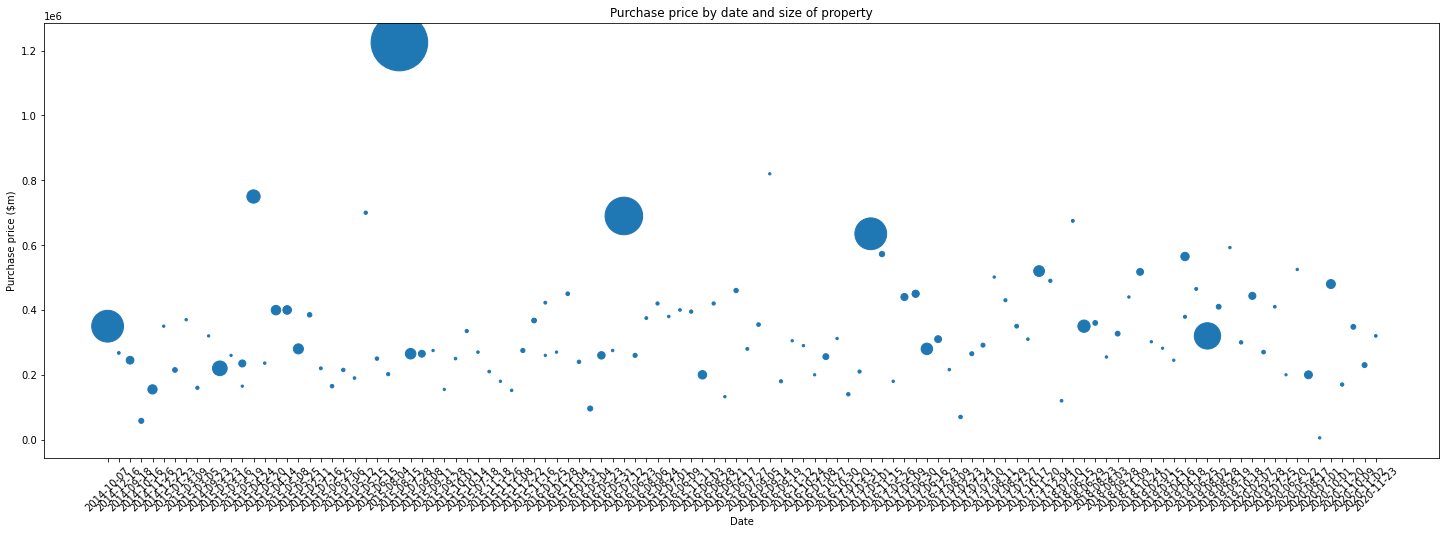

In [60]:
#Price by size

# Create figure and plot space
fig, ax = plt.subplots(figsize=(25, 8))

# Add x-axis and y-axis
ax.scatter(
       x=df_myarea.index.values,
       y=df_myarea['Purchase price'],
       s=df_myarea['Area']/200
       )

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Purchase price ($m)",
       title="Purchase price by date and size of property")

# Rotate tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

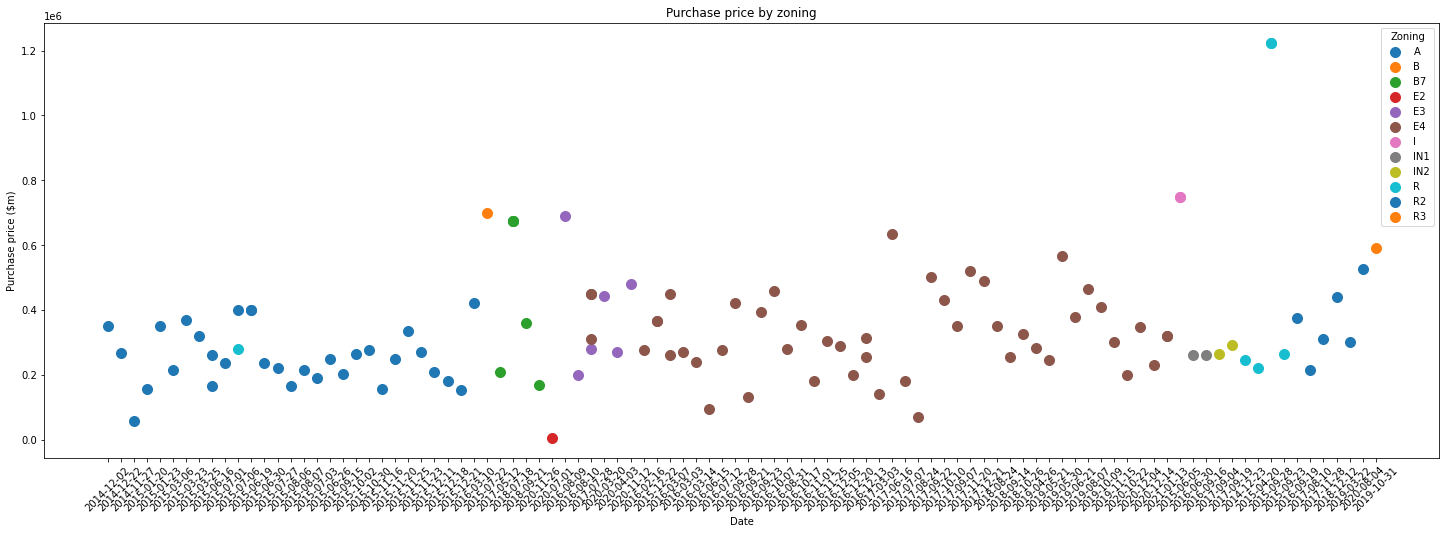

In [57]:
#Price by zoning

#Create figure and plot space
fig, ax = plt.subplots(figsize=(25, 8))

#Loop groups and create a scatter per group
for name, group in df_myarea.groupby('Zoning'):
    ax.scatter(x="Settlement date", y="Purchase price", data=group, label=name, s=100)

ax.legend(title="Zoning")

#Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Purchase price ($m)",
       title="Purchase price by zoning")

#Rotate tick marks on x-axis
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()